In [1]:
import json
import datetime
import re
import pandas as pd
import os
import numpy as np
import time
import pickle
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters
user_email='mehrdadb@uber.com'

# Query
from queryrunner_client import Client
qclient = Client(user_email=user_email, consumer_name='intelligentdispatch')

# Parallel processing
import multiprocessing
from joblib import Parallel, delayed
from p_tqdm import p_map
from functools import partial
from tqdm import tqdm, trange
num_cores = multiprocessing.cpu_count()
n_cores = num_cores - 20 if num_cores > 40 else 1

from collections import Counter

# Log
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

# LP solver
import pulp
from ortools.linear_solver import pywraplp

# scipy
import scipy.sparse as ss
from scipy.optimize import linprog

print("User email: {0}\n{1:d} cores are available for parallel".format(user_email,num_cores))

User email: mehrdadb@uber.com
48 cores are available for parallel


In [2]:
#0. Functions
#(1) Data Query

qry = """
with dispatch as (select
    datestr,
    msg.cityid,
    msg.ctplangenrequestuuid as plangen_uuid,
    msg.ctrequestuuid as scan_uuid,
    msg.jobuuid[1] as job_uuid,
    msg.supplyuuid,
    msg.planactiontype
from rawdata_user.kafka_hp_multileg_dispatched_plan_nodedup
where datestr between '{date_start}' and '{date_end}'
and msg.cityid = {city_id}
and msg.vehicleviewid = {vvid}
and msg.tenancy = 'uber/production'
and CARDINALITY(msg.jobuuid) > 0
-- The line below samples scans
and substr(msg.ctrequestuuid, 1, 1) = '{digit}'
),
plangen as (
select
    msg.jobs[1].uuid as job_uuid,
    msg.jobs[1].vvid as job_vvid,
    msg.supplyuuid,
    msg.scanuuid as plangen_uuid
from rawdata_user.kafka_hp_plangenerator_matching_plans_log_nodedup
where datestr between '{date_start}' and '{date_end}'
and msg.cityid = {city_id}
and msg.tenancy = 'uber/production'
--and msg.jobs[1].vvid = {vvid}
and msg.planstatus = 'eligible'
and CARDINALITY(msg.jobs) > 0
),

polysolve as (
select 
datestr,
msg.city_id,
msg.scan_uuid,
msg.is_overwritten,
msg.is_selected_shadow,
msg.job_uuid,
msg.supply_uuid
from rawdata_user.kafka_hp_multileg_poly_solve_logs_nodedup
where datestr between '{date_start}' and '{date_end}'
and msg.city_id = {city_id} --(1,6,7,8,12,13,14,19,20,23,24,25)
--and msg.is_overwritten
and substr(msg.scan_uuid, 1, 1) = '{digit}'

group by 1,2,3,4,5,6,7
 
),


mgv as (
select datestr,
       msg.city_id,
       msg.job_uuid,
       msg.client_uuid,
       msg.ct_request_uuid as plangen_uuid,
       msg.supply_uuid,
       msg.supply_plan_uuid as plan_uuid,
       msg.unadjusted_eta as unadjustedeta,
       msg.adjustedeta,
       round(1 - msg.solo_cancel_model_driver_accept_prob, 6) as d_proba,
       round(1 - msg.solo_cancel_model_rider_accept_prob, 6) as r_proba,
       round(1 - msg.spinner_survive_prob_before_next_scan, 6) as s_proba,
       msg.preferred_destination_adjustment,
       msg.calculator_type,
       msg.objective_value as of_value,
       msg.inconvenience_etd - msg.adjustedeta as trip_length
from   rawdata.kafka_hp_multileg_mgv_log_nodedup
where  datestr between '{date_start}' and '{date_end}'
and    msg.city_id = {city_id}
and    msg.tenancy = 'uber/production'
and    msg.vehicle_view_id = {vvid}
and    msg.flow_type = 'solo_batch'
--and    msg.calculator_type = 'markov_eta_v2'
and    msg.job_uuid <> msg.client_uuid
),

fact_trips as (
select uuid,
       driver_upfront_fare_usd,
       client_upfront_fare_usd,
       city_id
from   restricted_dwh.fact_trip
where  datestr between '{date_start}' and '{date_end}'
and    city_id = {city_id}
and    global_product_name = 'UberX'
),

test as (
select
    mgv.datestr,
    mgv.city_id,
    dispatch.scan_uuid,
    mgv.plangen_uuid,
    mgv.job_uuid,
    dispatch.planactiontype,
    mgv.supply_uuid,
    case when dispatch.supplyuuid = mgv.supply_uuid then 1 else 0 end as is_selected,
    mgv.unadjustedeta,
    mgv.adjustedeta,
    mgv.d_proba,
    mgv.r_proba,
    mgv.s_proba,
    mgv.preferred_destination_adjustment,
    mgv.of_value,
    mgv.trip_length,
    mgv.calculator_type,
--    case when p.is_overwritten then 'markoveta' else 'gb_centric_of' end as objective_function,
    p.is_overwritten,
    plangen.job_vvid as vvid,
    ft.driver_upfront_fare_usd,
    ft.client_upfront_fare_usd

from mgv
join plangen
on mgv.plangen_uuid = plangen.plangen_uuid 
and mgv.job_uuid = plangen.job_uuid
and mgv.supply_uuid = plangen.supplyuuid
join dispatch
on mgv.plangen_uuid = dispatch.plangen_uuid 
and mgv.job_uuid = dispatch.job_uuid

join polysolve p
on mgv.datestr = p.datestr 
and mgv.city_id = p.city_id
and dispatch.scan_uuid = p.scan_uuid
and mgv.job_uuid = p.job_uuid

join fact_trips ft
on mgv.job_uuid = ft.uuid
and mgv.city_id = ft.city_id


)
select 
t.*

from test t
where t.vvid = {vvid}
order by 1
"""

In [3]:
def graph_connectivity(scan):
    plan_count = scan.shape[0]
    job_list = list(set(scan['job_uuid']))
    supply_list = list(set(scan['supply_uuid']))
    plan_jobs = list(scan['job_uuid'])
    plan_supplies = list(scan['supply_uuid'])
    
    #initialize
    job_cluster = dict()
    for i in range(len(job_list)):
        job_cluster[job_list[i]] = i 
        
    supply_cluster = dict()
    for j in range(len(supply_list)):
        supply_cluster[supply_list[j]] = len(job_list) + j
        
    for j in range(plan_count):
        job_uuid = plan_jobs[j]
        supply_uuid = plan_supplies[j]
        # merge components
        if supply_cluster[supply_uuid] != job_cluster[job_uuid]:
            new_index = min(supply_cluster[supply_uuid], job_cluster[job_uuid])
            old_index = max(supply_cluster[supply_uuid], job_cluster[job_uuid])
            for key in job_cluster.keys():
                if job_cluster[key] == old_index:
                    job_cluster[key] = new_index
            for key in supply_cluster.keys():
                if supply_cluster[key] == old_index:
                    supply_cluster[key] = new_index           
    return job_cluster, supply_cluster

In [4]:
name_template = 'data/xp_data/matching_graph_city{city_id}_{vvid}_{date_start}_{date_end}_segment{hex_id}.csv'

# Query
def qry_df(digit: str,
           qry: str,
           date_start: str,
           date_end: str,
           city_id: int,
           vvid: int,
           qry_name: str):
    file_name = name_template.format(city_id=city_id, vvid=vvid, date_start=date_start, date_end=date_end, hex_id=digit)
    logging.info('working on ' + file_name)
    if os.path.exists(file_name) and os.path.getsize(file_name) > 400:
        return
    print(file_name)

#     name = f'{qry_name}_city{city_id}_{vvid}_{date_start}_{date_end}_segment{digit}'
#     logging.info('working on ' + name)
    qry = qry.format(city_id=city_id, vvid=vvid, digit=digit, date_start=date_start, date_end=date_end)
#     print(qry)
    execution = qclient.execute('presto-secure', qry)
    data = execution.fetchall()
    df = pd.DataFrame(execution.load_data())
    n = len(df)
    if n > 0:
        df.to_csv(file_name, index=False)
    logging.info('done with ' + file_name)
    print('All done!')

    
def qry_df_for_dates_and_cities(digit: str,
           qry: str,
           dates: list,
           city_ids: list,
           vvids: list,
           qry_name: str):
    for date_start in dates:
        date_end = date_start
        for i in range(len(city_ids)):
            city_id = city_ids[i]
            vvid = vvids[i]
            qry_df(digit=digit, qry=qry, date_start=date_start, date_end=date_end, 
                   city_id=city_id, vvid=vvid, qry_name=qry_name)

def run_dates_parallel(hex_digits: list,
                       qry: str,
                       city_id: int,
                       vvid: int,
                       date_start: str,
                       date_end: str,
                       qry_name: str):
    Parallel(n_jobs=n_cores)(delayed(qry_df)(digit=hex_digit, qry=qry, date_start=date_start, date_end=date_end, 
                                             city_id=city_id, vvid=vvid, qry_name=qry_name) 
                             for hex_digit in hex_digits)

def run_hex_parallel_for_dates_and_cities(hex_digits: list,
                       qry: str,
                       city_ids: list,
                       vvids: list,
                       dates: list,
                       qry_name: str):
    Parallel(n_jobs=n_cores)(delayed(qry_df_for_dates_and_cities)(digit=hex_digit, qry=qry, dates=dates, 
                                             city_ids=city_ids, vvids=vvids, qry_name=qry_name) 
                             for hex_digit in hex_digits)

def run_cities_parallel_date_and_hex(hex_digit: str,
                       qry: str,
                       city_ids: list,
                       vvids: list,
                       date: str,
                       qry_name: str):
    Parallel(n_jobs=n_cores)(delayed(qry_df)(digit=hex_digit, qry=qry, date_start=date, date_end=date, 
                                             city_id=city_ids[i], vvid=vvids[i], qry_name=qry_name) 
                             for i in range(len(city_ids)))

def mp_data_query(hex_digits: list,
                  qry: str,
                  city_id: int,
                  vvid: int,
                  date_start: str,
                  date_end: str,
                  qry_name: str):
    p_map(partial(qry_df, qry = qry, date_start = date_start, date_end = date_end, 
                  city_id = city_id, vvid = vvid, qry_name = qry_name), hex_digits)

def mp_data_query_parallel_dates(hex_digits: list,
                                 qry: str,
                                 city_id: int,
                                 vvid: int,
                                 dates: list,
                                 qry_name: str):
    Parallel(n_jobs=n_cores)(delayed(mp_data_query)(hex_digits=hex_digits, qry=qry, date_start=date_start, date_end=date_start, 
                                             city_id=city_id, vvid=vvid, qry_name=qry_name) 
                             for date_start in dates)

def mp_data_query_parallel_dates_and_cities(hex_digits: list,
                                            qry: str,
                                            city_ids: list,
                                            vvids: list,
                                            dates: list,
                                            qry_name: str):
    Parallel(n_jobs=n_cores)(delayed(mp_data_query_parallel_dates)(hex_digits=hex_digits, qry=qry, dates=dates, 
                                             city_id=city_ids[i], vvid=vvids[i], qry_name=qry_name) 
                             for i in range(len(city_ids)))


In [5]:
#(2) LP solver
def matching_graph_resolve(scan, OF_values, job_singleton = 1500):
    plan_count = scan.shape[0]
    job_list = list(set(scan['job_uuid']))
    supply_list = list(set(scan['supply_uuid']))
    plan_jobs = list(scan['job_uuid'])
    plan_supplies = list(scan['supply_uuid'])
    
    # Create all plans
    actual_plans = [tuple([plan_jobs[i],plan_supplies[i]]) for i in range(plan_count)]
    singleton_plans = [tuple([j]) for j in job_list]
    all_plans = actual_plans + singleton_plans
    
    # Create solver
    solver = pywraplp.Solver.CreateSolver('GLOP')
    
    # Create variables
    x = {}
    for plan in all_plans:
        x[plan] = solver.NumVar(0, 1, '')
        
    # Create constraint
    for j in job_list:
        solver.Add(solver.Sum([x[v] for v in all_plans if j in v]) == 1)
    for s in supply_list:
        solver.Add(solver.Sum([x[v] for v in all_plans if s in v]) <= 1)
    
    # Create Obj function
    solver.Minimize(solver.Sum([OF_values[i] * x[actual_plans[i]] for i in range(plan_count)] + 
                                 [job_singleton * x[singleton_plans[j]] for j in range(len(singleton_plans))]) )
    
    # Solve
    status = solver.Solve()
            
    return set([v for v in all_plans if x[v].solution_value() == 1.0 ])

In [6]:
#(3) Polysolve
def is_contention_relaxed(scan, 
                          default_matching,
                          buffer = 60,  
                          suboptimal_percentage_threshold = 0.2,
                          singleton_cost = 1500):
    total_job = len(set(scan['job_uuid']))
    suboptimal_job = 0
    for m in default_matching:
        if len(m) == 1:
            matched_of = singleton_cost
        else:
            matched_of = list(scan[(scan['job_uuid']==m[0])&(scan['supply_uuid']==m[1])]['of_value'])[0]
        best_supply_of = min(scan[scan['job_uuid']==m[0]]['of_value'])
        if matched_of > best_supply_of + buffer:
            suboptimal_job += 1
    if suboptimal_job > total_job * suboptimal_percentage_threshold:
        return True
    else:
        return False
    
def polysolve_markov_gb(scan, 
                        buffer = 60,  
                        suboptimal_percentage_threshold = 0.2,
                        primary_singleton = 1500,
                        secondary_singleton = 1.0):
    primary_matching = matching_graph_resolve(scan, list(scan['of_value']), job_singleton = primary_singleton)
    if is_contention_relaxed(scan, 
                             primary_matching,
                             buffer = buffer,  
                             suboptimal_percentage_threshold = suboptimal_percentage_threshold,
                             singleton_cost = primary_singleton):
        secondary_matching = matching_graph_resolve(scan, list(scan['new_of']), job_singleton = secondary_singleton)
        different_matches = len(different_matching_decision(primary_matching, secondary_matching)[0])
        return secondary_matching, 1, different_matches
    else:
        return primary_matching, 0, 0 

def different_matching_decision(m1,m2):
    return m1.difference(m2), m2.difference(m1)

In [7]:
def compute_expected_gb(scan):
    # Imputations
    scan['d_proba'] = scan['d_proba'].fillna(0.5)
    scan['r_proba'] = scan['r_proba'].fillna(0.2)
    scan['s_proba'] = scan['s_proba'].fillna(0.01)
    
    scan['expected_gb'] = (1 - scan['d_proba']) * (1 - scan['r_proba']) * (1 - scan['s_proba']) * scan['client_upfront_fare_usd']

    return scan

In [8]:
#(5) Define metrics
def eta_gb_contention_metrics(scan, matching):
    total_jobs = len(matching)
    offered_eta = []
    offered_gb = []
    for m in matching:
        if len(m) == 2:
            tmp_df = scan[(scan['job_uuid']==m[0])&(scan['supply_uuid']==m[1])]
#             if list(tmp_df['trip_length'])[0] > 7200:
#                 continue
            expected_gb = (1 - list(tmp_df['d_proba'])[0]) * (1 - list(tmp_df['r_proba'])[0]) * (1 - list(tmp_df['s_proba'])[0]) * list(tmp_df['client_upfront_fare_usd'])[0]
            offered_gb.append(expected_gb)
            offered_eta.append(list(tmp_df['unadjustedeta'])[0])
    return total_jobs, offered_eta, offered_gb


def metric_summary(scan, matching):
    total_jobs = len(matching)
    total_eta = 0
    total_trip_duration = 0
    matched_jobs = 0
    driver_cancel = 0
    rider_cancel = 0
    for m in matching:
        if len(m) == 2:
            tmp_df = scan[(scan['job_uuid']==m[0])&(scan['supply_uuid']==m[1])]
            if list(tmp_df['trip_length'])[0] > 7200:
                continue
            matched_jobs += 1
            total_eta += list(tmp_df['eta'])[0]
            total_trip_duration += list(tmp_df['trip_length'])[0]
            driver_cancel += list(tmp_df['d_proba'])[0]
            rider_cancel += list(tmp_df['r_proba'])[0]
    if matched_jobs > 0:
        average_eta = total_eta *1.0 / matched_jobs
        average_trip_duration = total_trip_duration * 1.0 / matched_jobs
        average_driver_cancel = driver_cancel * 1.0 / matched_jobs
        average_rider_cancel = rider_cancel * 1.0 / matched_jobs
    else:
        average_eta = 0
        average_trip_duration = 0
        average_driver_cancel = 0
        average_rider_cancel = 0
    return total_jobs, matched_jobs, average_eta, average_trip_duration, average_driver_cancel, average_rider_cancel


def complete_metric_summary(df, 
                            buffer = 60,  
                            suboptimal_percentage_threshold = 0.2,
                            primary_singleton = 1500,
                            secondary_singleton = 1.0,
                            exp_d = 1.0,
                            exp_r = 1.0,
                            exp_s = 1.0, 
                            gb_over_supplyhour_weight = 1.0):
    markov_df = df[df['of_value']>1]
    total_scans = list(set(markov_df['scan_uuid']))
    total_requested_jobs = 0
    total_matched_jobs = 0
    total_eta = 0
    total_trip_length = 0
    total_driver_cancel = 0
    total_rider_cancel = 0
    total_overwrite_scans = 0
    total_different_matches = 0
    
    for i in range(len(total_scans)):
        scan = markov_df[markov_df['scan_uuid'] == total_scans[i]]
        scan = compute_new_of(scan, exp_d = exp_d, exp_r = exp_r, exp_s = exp_s, gb_over_supplyhour_weight = gb_over_supplyhour_weight)
        matching, overwrite, different_matches = polysolve_markov_gb(scan, 
                                       buffer = buffer,  
                                       suboptimal_percentage_threshold = suboptimal_percentage_threshold,
                                       primary_singleton = primary_singleton,
                                       secondary_singleton = secondary_singleton)
        total_jobs, matched_jobs, average_eta, average_trip_duration, average_driver_cancel, average_rider_cancel = metric_summary(scan, matching)
        total_overwrite_scans += overwrite
        total_different_matches += different_matches
        total_requested_jobs += total_jobs
        total_matched_jobs += matched_jobs
        total_eta += average_eta * matched_jobs
        total_trip_length += average_trip_duration * matched_jobs
        total_driver_cancel += average_driver_cancel * matched_jobs
        total_rider_cancel += average_rider_cancel * matched_jobs
    return {'total_jobs': total_requested_jobs, 
            'matched_jobs': total_matched_jobs * 1.0 / total_requested_jobs,
            'overwrite_rate': total_overwrite_scans * 1.0 / len(total_scans),
            'different_matches_rate': total_different_matches * 1.0 /  total_requested_jobs,
            'ETA': total_eta * 1.0 / total_matched_jobs,
            'trip_length': total_trip_length * 1.0 / total_matched_jobs,
            'driver_AR': 1 - total_driver_cancel * 1.0 / total_matched_jobs,
            'rider_cancel': total_rider_cancel* 1.0 / total_matched_jobs           
           }

In [9]:
xp_cities = [805, 148, 204, 781, 144, 146, 533, 1408, 1315, 1359, 1395, 1379, 1388, 1325, 1390, 1423, 1335, 1275]
vvids = [12137, 3227, 2494, 4395, 1572, 1934, 2875, 20000337, 10002424, 10004380, 10001042, 10002430, 20003055, 10002534, 10004784, 10000418, 10002564, 10001040]
hex_digits =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f']
dates = ['2022-01-13','2022-01-14','2022-01-15','2022-01-16','2022-01-17','2022-01-18','2022-01-19','2022-01-20','2022-01-21','2022-01-22','2022-01-23','2022-01-24','2022-01-25','2022-01-26','2022-01-27']
name_template = 'data/xp_data/matching_graph_city{city_id}_{vvid}_{date_start}_{date_end}_segment{hex_id}.csv'

## mp_data_query_parallel_dates_and_cities(hex_digits=hex_digits, qry=qry, city_ids=xp_cities, vvids=vvids,
##                                  dates=dates, qry_name = "matching_graph")

# This one was the most useful for loading the data
# run_hex_parallel_for_dates_and_cities(hex_digits=hex_digits, qry=qry, city_ids=xp_cities, vvids=vvids,
#                                       dates=dates, qry_name = "matching_graph")

# run_cities_parallel_date_and_hex(hex_digit='5', qry=qry, city_ids=xp_cities, vvids=vvids,
#                                  date=dates[-1], qry_name="matching_graph")


for i in range(0):#range(1, len(xp_cities)):
    city_id = xp_cities[i]
    vvid = vvids[i]
#     mp_data_query_parallel_dates(hex_digits = hex_digits, qry = qry, city_id = city_id, vvid = vvid,
#                                  dates=dates, qry_name = "matching_graph")
#     continue
    for start_date in dates:
#         mp_data_query(hex_digits = hex_digits, qry = qry, city_id = city_id, vvid = vvid,
#                            date_start = start_date, date_end = start_date, qry_name = "matching_graph")
        run_dates_parallel(hex_digits = hex_digits, qry = qry, city_id = city_id, vvid = vvid,
                           date_start = start_date, date_end = start_date, qry_name = "matching_graph")

In [10]:

for i in range(0, 0):#len(xp_cities)):
    if i < 4:
        continue
    city_id = xp_cities[i]
    vvid = vvids[i]
    for digit in hex_digits:
        date_start = '2022-01-13'
        date_end = '2022-01-13'
        file_name = name_template.format(city_id=city_id, vvid=vvid, date_start=date_start, date_end=date_end, hex_id=digit)
#         file_name = f'{qry_name}_city{city_id}_{vvid}_{date_start}_{date_end}_segment{digit}'
        logging.info('working on ' + file_name)
        if os.path.exists(file_name) and os.path.getsize(file_name) > 400:
            continue
        print(file_name)

        qry = qry.format(city_id=city_id, vvid=vvid, digit=digit, date_start=date_start, date_end=date_end)
#         print(qry)
        execution = qclient.execute('presto-secure', qry)
#         data = execution.fetchall()
        df = pd.DataFrame(execution.load_data())
        n = len(df)
        print('len(df): ', len(df))
        df.to_csv(file_name, index=False)
        logging.info('done with ' + file_name)
        print('All done!')



In [11]:
# qclient.poll('e22684d5-6b19-4647-a4a6-2cd6d1cd9c49')

In [12]:
def get_offered_eta(scan):
    etas = []
    for index, row in scan.iterrows():
        if not row['is_selected']:
            continue
        if row['is_overwritten'] and row['calculator_type']=='gb_centric_fare_of':
            etas.append(row['adjustedeta'])
        elif not row['is_overwritten'] and row['calculator_type']=='markov_eta_v2':
            etas.append(row['adjustedeta'])
    if len(etas) == 0:
        return None
    return sum(etas) / float(len(etas))

def get_expected_gb_of_offers(scan):
    gbs = []
    for index, row in scan.iterrows():
        if not row['is_selected']:
            continue
        exp_gb = (1 - row['d_proba']) * (1 - row['r_proba']) * (1 - row['s_proba']) * row['client_upfront_fare_usd']
        if row['is_overwritten'] and row['calculator_type']=='gb_centric_fare_of':
            gbs.append(exp_gb)
        elif not row['is_overwritten'] and row['calculator_type']=='markov_eta_v2':
            gbs.append(exp_gb)
    if len(gbs) == 0:
        return None
    return sum(gbs) / float(len(gbs))

def get_offered_eta_and_gb_of_scan(scan):
    gbs = []
    etas = []
    etas_per_cluster = defaultdict(lambda:[])
    gb_per_cluster = defaultdict(lambda:[])
    overwriten_clusters = set()
    for index, row in scan.iterrows():
        if not row['is_selected']:
            continue
        cluster_size = row['cluster_size']
        if row['is_overwritten']:
            overwriten_clusters.add(row['cluster_index'])
        exp_gb = (1 - row['d_proba']) * (1 - row['r_proba']) * (1 - row['s_proba']) * row['client_upfront_fare_usd']
        if row['is_overwritten'] and row['calculator_type']=='gb_centric_fare_of':
            etas.append(row['adjustedeta'])
            gbs.append(exp_gb)
            etas_per_cluster[cluster_size].append(row['adjustedeta'])
            gb_per_cluster[cluster_size].append(exp_gb)
        elif not row['is_overwritten'] and row['calculator_type']=='markov_eta_v2':
            etas.append(row['adjustedeta'])
            gbs.append(exp_gb)
            etas_per_cluster[cluster_size].append(row['adjustedeta'])
            gb_per_cluster[cluster_size].append(exp_gb)
    if len(gbs) == 0:
        return None, None, None, None, None
    return sum(etas) / float(len(etas)), sum(gbs) / float(len(gbs)), etas_per_cluster, gb_per_cluster, overwriten_clusters

def get_offered_eta_per_cluster_size(scan):
    etas_per_cluster = defaultdict(lambda:[])
    for index, row in scan.iterrows():
        if not row['is_selected']:
            continue
        cluster_size = row['cluster_size']
        if row['is_overwritten'] and row['calculator_type']=='gb_centric_fare_of':
            etas_per_cluster[cluster_size].append(row['adjustedeta'])
        elif not row['is_overwritten'] and row['calculator_type']=='markov_eta_v2':
            etas_per_cluster[cluster_size].append(row['adjustedeta'])
#     if len(etas) == 0:
#         return None
#     return sum(etas) / float(len(etas))
    return etas_per_cluster

def is_overwriten(scan):
    return len(scan) > 0 and scan['is_overwritten'].iloc[0]

In [41]:
#2. Resolve
# Create df_list

df_list   = []
df_all_scans = None
df_list_cities = []

#for date in date_list:
for i, city_id in enumerate(xp_cities):#xp_cities[:1]):
    city_id = xp_cities[i] 
    vvid =  vvids[i]
    for date in dates:
        for hex_id in hex_digits[:1]:
            print(name_template.format(city_id=city_id, vvid=vvid, date_start=date, 
                                                  date_end=date, hex_id=hex_id))
            df_list_cities.append(city_id)
            tmp_df = pd.read_csv(name_template.format(city_id=city_id, vvid=vvid, date_start=date, 
                                                  date_end=date, hex_id=hex_id))
            df_list.append(tmp_df)

            if df_all_scans is None:
                df_all_scans = tmp_df
            else:
                df_all_scans = pd.concat([df_all_scans,tmp_df])

            

data/xp_data/matching_graph_city805_12137_2022-01-13_2022-01-13_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-14_2022-01-14_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-15_2022-01-15_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-16_2022-01-16_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-17_2022-01-17_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-18_2022-01-18_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-19_2022-01-19_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-20_2022-01-20_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-21_2022-01-21_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-22_2022-01-22_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-23_2022-01-23_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-24_2022-01-24_segment0.csv
data/xp_data/matching_graph_city805_12137_2022-01-25_2022-01-25_segment0.csv

data/xp_data/matching_graph_city1408_20000337_2022-01-16_2022-01-16_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-17_2022-01-17_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-18_2022-01-18_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-19_2022-01-19_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-20_2022-01-20_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-21_2022-01-21_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-22_2022-01-22_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-23_2022-01-23_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-24_2022-01-24_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-25_2022-01-25_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-26_2022-01-26_segment0.csv
data/xp_data/matching_graph_city1408_20000337_2022-01-27_2022-01-27_segment0.csv
data/xp_data/matching_graph_

data/xp_data/matching_graph_city1390_10004784_2022-01-15_2022-01-15_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-16_2022-01-16_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-17_2022-01-17_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-18_2022-01-18_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-19_2022-01-19_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-20_2022-01-20_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-22_2022-01-22_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-23_2022-01-23_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-24_2022-01-24_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-25_2022-01-25_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-26_2022-01-26_segment0.csv
data/xp_data/matching_graph_city1390_10004784_2022-01-27_2022-01-27_segment0.csv
data/xp_data/matching_graph_

In [ ]:
from collections import defaultdict
df_all_scans
scan_uuids = list(set(df_all_scans['scan_uuid']))
print(len(scan_uuids))
density_eta = defaultdict(lambda:[])
density_gb = defaultdict(lambda:[])

eta_per_cluster_size = defaultdict(lambda:[])
gb_per_cluster_size = defaultdict(lambda:[])
overwrites_to_cluster_count = defaultdict(lambda:0)
size_to_cluster_count = defaultdict(lambda:0)
overwrite_rate_per_cluster_size = defaultdict(lambda:0)

import time

# for number, scan_uuid in enumerate(scan_uuids):
number = 0
for df_item in df_list:
    scan_uuids = list(set(df_item['scan_uuid']))
    for scan_uuid in scan_uuids:
        if number % 100 == 0:
            print(number, time.time())
        number += 1
        scan = df_item.loc[df_item.scan_uuid==scan_uuid]
    #     scan = df_all_scans.loc[df_all_scans.scan_uuid==scan_uuid]
    #         scan = scan.reset_index(drop=True)
        # Imputation
        scan['d_proba'] = scan['d_proba'].fillna(0.5)
        scan['r_proba'] = scan['r_proba'].fillna(0.2)
        scan['s_proba'] = scan['s_proba'].fillna(0.01)

        job_cluster, supply_cluster = graph_connectivity(scan)
        cluster_size_dict = Counter(job_cluster.values())
        job_cluster_column = []
        cluster_size_column = []
    #         for i in range(len(scan['job_uuid'])):
        for i, _row in scan.iterrows():
            cluster_id = job_cluster[scan['job_uuid'][i]]
            job_cluster_column.append(cluster_id)
            cluster_size_column.append(cluster_size_dict[cluster_id])
        scan['cluster_index'] = job_cluster_column
        scan['cluster_size'] = cluster_size_column
        avg_offered_eta, avg_expected_gb_of_offers, eta_per_cluster, gb_per_cluster, overwritten_clusters = get_offered_eta_and_gb_of_scan(scan)
        if avg_offered_eta is None:
            continue
        #overwritten clusters is cluster_index of overwritten ones
        # compute overwrite per cluster size with a for loop
        for cluster_index, cluster_size in cluster_size_dict.items():
            size_to_cluster_count[cluster_size] += 1
            if cluster_index in overwritten_clusters:
                overwrites_to_cluster_count[cluster_size] += 1
            eta_per_cluster_size[cluster_size] += eta_per_cluster[cluster_size]
            gb_per_cluster_size[cluster_size] += gb_per_cluster[cluster_size]

        secondary_plans = scan.loc[scan.calculator_type=='gb_centric_fare_of']
        e_v = len(secondary_plans) / float(len(set(secondary_plans['job_uuid'])))

        if avg_offered_eta:
            density_eta[int(e_v)].append(avg_offered_eta)
            density_gb[int(e_v)].append(avg_expected_gb_of_offers)

for c_size, c_count in size_to_cluster_count.items():
    overwrite_rate_per_cluster_size[c_size] = overwrites_to_cluster_count[c_size] / float(c_count) if c_count > 0 else 0
# scan.columns

103498
0 1661192816.783236
100 1661192876.6452775
200 1661192928.3597064
300 1661192983.93186
400 1661193047.9627967
500 1661193107.4455857
600 1661193170.3263474
700 1661193236.3352172
800 1661193298.961191
900 1661193364.212873
1000 1661193416.2195697
1100 1661193470.8338587
1200 1661193526.119395
1300 1661193584.8058639
1400 1661193646.8452213
1500 1661193707.2607038
1600 1661193764.6318126
1700 1661193830.6557112
1800 1661193892.5485675
1900 1661193949.188812
2000 1661194011.842019
2100 1661194077.4196334
2200 1661194145.0939698
2300 1661194217.0213861
2400 1661194290.0283902
2500 1661194362.768339
2600 1661194442.706141
2700 1661194523.861844
2800 1661194608.0015032
2900 1661194680.6874447
3000 1661194746.5926352
3100 1661194812.564759
3200 1661194874.401851
3300 1661194939.0871196
3400 1661195006.9215426
3500 1661195069.017485
3600 1661195130.5140967
3700 1661195193.026748
3800 1661195259.2454224
3900 1661195325.3386426
4000 1661195410.0948815
4100 1661195494.9528885
4200 1661195

In [55]:
x = []
y = []
percentile_33 = []
percentile_66 = []
for key in sorted(density_gb.keys()):
    if len(density_gb[key]) <= 5 or key > 59:
        continue
#     print(len(density_gb[key]))
    x.append(key)
    y.append(np.median(np.array(density_gb[key])))
    percentile_33.append(np.percentile(np.array(density_gb[key]), 33))
    percentile_66.append(np.percentile(np.array(density_gb[key]), 66))
#     print(key, np.median(np.array(density_gb[key])), len(density_gb[key]))

plt.title('Effect of graph density on GB')
plt.xlabel('Graph Density (|E|/|V|)')
plt.ylabel('Expected GB per offer')
plt.plot(x, y)
plt.fill_between(x, percentile_33, percentile_66, alpha = 0.2, label="Quantile 33-66")
# plt.show()
plt.savefig('GB_graph_density.png', dpi=300)

NameError: name 'density_gb' is not defined

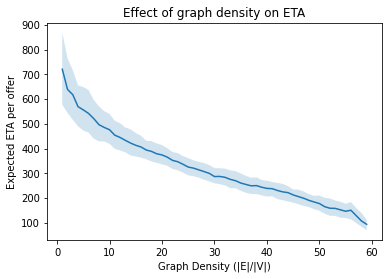

In [22]:
x = []
y = []
percentile_33 = []
percentile_66 = []
for key in sorted(density_eta.keys()):
    if len(density_eta[key]) <= 5 or key > 59:
        continue
    x.append(key)
    y.append(np.median(np.array(density_eta[key])))
    percentile_33.append(np.percentile(np.array(density_eta[key]), 33))
    percentile_66.append(np.percentile(np.array(density_eta[key]), 66))

plt.title('Effect of graph density on ETA')
plt.xlabel('Graph Density (|E|/|V|)')
plt.ylabel('Expected ETA per offer')
plt.plot(x, y)
plt.fill_between(x, percentile_33, percentile_66, alpha = 0.2, label="Quantile 33-66")
# plt.show()
plt.savefig('ETA_graph_density.png', dpi=300)

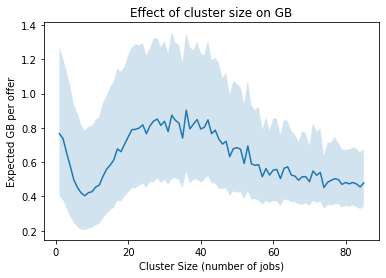

In [23]:
for key in sorted(eta_per_cluster_size.keys()):
#     print(key, gb_per_cluster_size[key])
    if len(eta_per_cluster_size[key]) <= 5:
        continue
    pass
#     print(key, np.median(np.array(eta_per_cluster_size[key])), len(eta_per_cluster_size[key]))

x = []
y = []
percentile_33 = []
percentile_66 = []
for key in sorted(gb_per_cluster_size.keys()):
    if len(gb_per_cluster_size[key]) <= 5 or key > 85:
        continue
    x.append(key)
    y.append(np.median(np.array(gb_per_cluster_size[key])))
    percentile_33.append(np.percentile(np.array(gb_per_cluster_size[key]), 33))
    percentile_66.append(np.percentile(np.array(gb_per_cluster_size[key]), 66))

plt.title('Effect of cluster size on GB')
plt.ylabel('Expected GB per offer')
plt.xlabel('Cluster Size (number of jobs)')
plt.plot(x, y)
plt.fill_between(x, percentile_33, percentile_66, alpha = 0.2, label="Quantile 33-66")
# plt.show()
plt.savefig('GB_cluster_size.png', dpi=300)

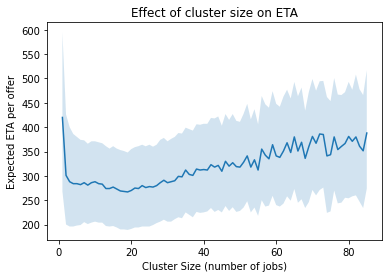

In [24]:
x = []
y = []
percentile_33 = []
percentile_66 = []
for key in sorted(eta_per_cluster_size.keys()):
    if len(eta_per_cluster_size[key]) <= 5 or key > 85:
        continue
    x.append(key)
    y.append(np.median(np.array(eta_per_cluster_size[key])))
    percentile_33.append(np.percentile(np.array(eta_per_cluster_size[key]), 33))
    percentile_66.append(np.percentile(np.array(eta_per_cluster_size[key]), 66))

plt.title('Effect of cluster size on ETA')
plt.ylabel('Expected ETA per offer')
plt.xlabel('Cluster Size (number of jobs)')
plt.plot(x, y)
plt.fill_between(x, percentile_33, percentile_66, alpha = 0.2, label="Quantile 33-66")
# plt.show()
plt.savefig('ETA_cluster_size.png', dpi=300)

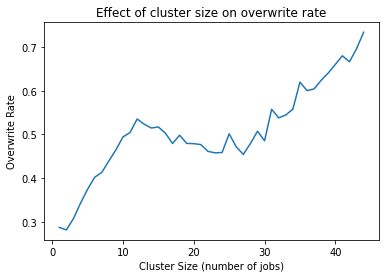

In [25]:
overwrite_rate_per_cluster_size

x = []
y = []
percentile_33 = []
percentile_66 = []
for key in sorted(overwrite_rate_per_cluster_size.keys()):
#     if len(eta_per_cluster_size[key]) <= 5 or key > 85:
#         continue
    if key > 44:
        continue
    x.append(key)
    y.append(np.median(np.array(overwrite_rate_per_cluster_size[key])))
#     percentile_33.append(np.percentile(np.array(eta_per_cluster_size[key]), 33))
#     percentile_66.append(np.percentile(np.array(eta_per_cluster_size[key]), 66))

plt.title('Effect of cluster size on overwrite rate')
plt.ylabel('Overwrite Rate')
plt.xlabel('Cluster Size (number of jobs)')
plt.plot(x, y)
# plt.fill_between(x, percentile_33, percentile_66, alpha = 0.2, label="Quantile 33-66")
# plt.show()
plt.savefig('Overwrite_rate_cluster_size.png', dpi=300)

In [15]:
pd.reset_option("max_columns")
pd.set_option("max_columns", 30)
scan.head(10)

NameError: name 'scan' is not defined

In [50]:
deltaGB_deltaETA_and_ETA = []
deltaGB_deltaETA_and_GB = []

markov_ETA = []
markov_GB = []
polysolve_ETA = []
polysolve_GB = []
polysolve3_ETA = []
polysolve3_GB = []
# non_contention_ETA = []
# non_contention_GB = []

overwrite_gained_gb = []
overwrite_gained_ETA = []

smart_ow_gained_gb = []
smart_ow_gained_ETA = []

overwrite_cutoff = 0.9

primary_singleton = 1500
secondary_singleton = 12300
# 448

total = 0
excluded = 0

total_plans_map = defaultdict(lambda: 0)
excluded_plans_map = defaultdict(lambda: 0)

# for number, scan_uuid in enumerate(scan_uuids):
#     if number % 100 == 0:
#         print(number, time.time())
#     number += 1
#     scan = df_all_scans.loc[df_all_scans.scan_uuid==scan_uuid]
number = 0
for i, df_item in enumerate(df_list):
    scan_uuids = list(set(df_item['scan_uuid']))
    for scan_uuid in scan_uuids:
        if number % 100 == 0:
            print(number, time.time())
        number += 1
        scan = df_item.loc[df_item.scan_uuid==scan_uuid]
        city_id = df_list_cities[i]
#         if city_id not in [805, 204, 781, 144, 146, 533, 1315, 1359, 1395, 1325, 1275]:
#             continue

#         scan = scan.reset_index(drop=True)
        # Imputation
        scan['d_proba'] = scan['d_proba'].fillna(0.5)
        scan['r_proba'] = scan['r_proba'].fillna(0.2)
        scan['s_proba'] = scan['s_proba'].fillna(0.01)

        #compute primary_ETA, primary_GB, secondary_ETA, secondary_GB
        primary_scan = scan.loc[scan.calculator_type=='markov_eta_v2']
        secondary_scan = scan.loc[scan.calculator_type=='gb_centric_fare_of']
        all_plans = len(secondary_scan)
        excluded_plans = len(secondary_scan.loc[secondary_scan.of_value>=448])
        total += all_plans
        excluded += excluded_plans
        total_plans_map[city_id] += all_plans
        excluded_plans_map[city_id] += excluded_plans
#         print(excluded, total)
        continue

        m1 = matching_graph_resolve(primary_scan, list(scan['of_value']), job_singleton = primary_singleton)
        m2 = matching_graph_resolve(secondary_scan, list(scan['of_value']), job_singleton = secondary_singleton)
        different_matches = len(different_matching_decision(m1, m2)[0])
        m1_jobs, m1_etas, m1_gbs = eta_gb_contention_metrics(primary_scan, m1)
        m2_jobs, m2_etas, m2_gbs = eta_gb_contention_metrics(secondary_scan, m2)
        contention_overwrite = is_overwriten(scan)
        if contention_overwrite:
    #         if len(m2_etas):
    #             contention_ETA += [sum(m2_etas)/len(m2_etas)]
            polysolve_ETA += m2_etas
    #             contention_GB += [sum(m2_gbs) / len(m2_gbs)]
            polysolve_GB += m2_gbs
            if len(m1_etas) and len(m2_etas):
                overwrite_gained_ETA.append(sum(m2_etas)/len(m2_etas) - sum(m1_etas)/len(m1_etas))
            overwrite_gained_gb.append(sum(m2_gbs) - sum(m1_gbs))
        else:
    #         if len(m1_etas):
    #             non_contention_ETA += [sum(m1_etas)/len(m1_etas)]
    #             non_contention_GB += [sum(m1_gbs)/len(m1_gbs)]
            polysolve_ETA += m1_etas
            polysolve_GB += m1_gbs
        markov_ETA += m1_etas
        markov_GB += m1_gbs

        deltaGB = (sum(m2_gbs) - sum(m1_gbs)) / sum(m1_gbs) if len(m1_gbs) else 0
        deltaETA = (sum(m2_etas) - sum(m1_etas)) / sum(m1_etas) if len(m1_etas) else 0
        dGB_dETA = 0
        if deltaGB < 0 and deltaETA < 0:
            dGB_dETA = -1e10
    #         m2_gbs, m1_gbs = m1_gbs, m2_gbs
    #         m2_etas, m1_etas = m1_etas, m2_etas
        elif deltaGB != 0 and deltaETA == 0:
            dGB_dETA = 1e10 * np.sign(deltaGB)
        elif deltaGB != 0 and deltaETA != 0:
            dGB_dETA = deltaGB / deltaETA
        if dGB_dETA < 0:
            if deltaGB < 0:
                dGB_dETA = -1e10
            else:
                dGB_dETA = 1e10
        deltaGB_deltaETA_and_ETA.append(dGB_dETA)
        if dGB_dETA > overwrite_cutoff:
            polysolve3_GB += m2_gbs
            polysolve3_ETA += m2_etas
            smart_ow_gained_gb.append(sum(m2_gbs) - sum(m1_gbs))
            if len(m1_etas) and len(m2_etas): 
                smart_ow_gained_ETA.append(sum(m2_etas)/len(m2_etas) - sum(m1_etas)/len(m1_etas))
        else:
            polysolve3_GB += m1_gbs
            polysolve3_ETA += m1_etas

0 1645303317.306813
100 1645303336.0721734
200 1645303355.7510946
300 1645303375.4085655
400 1645303396.2258162
500 1645303416.334214
600 1645303437.7718973
700 1645303460.2259011
800 1645303483.1467361
900 1645303502.6873267
1000 1645303524.1096413
1100 1645303542.7543938
1200 1645303561.5538552
1300 1645303584.5884962
1400 1645303605.386381
1500 1645303626.8885136
1600 1645303645.945987
1700 1645303663.940195
1800 1645303685.1603925
1900 1645303707.3677883
2000 1645303727.664521
2100 1645303746.69495
2200 1645303766.9269867
2300 1645303788.0835433
2400 1645303810.6135416
2500 1645303830.3803225
2600 1645303852.2501605
2700 1645303875.8110085
2800 1645303898.1016128
2900 1645303920.4487016
3000 1645303942.9629376
3100 1645303963.5681336
3200 1645303984.8579812
3300 1645304003.1981921
3400 1645304023.3918912
3500 1645304042.347666
3600 1645304061.7127168
3700 1645304080.7364624
3800 1645304102.5654163
3900 1645304125.3645418
4000 1645304147.6796446
4100 1645304172.7129111
4200 16453042

36200 1645310944.605627
36300 1645310964.6984577
36400 1645310984.3070056
36500 1645311005.8752902
36600 1645311027.6782415
36700 1645311047.038398
36800 1645311067.7914128
36900 1645311085.7354152
37000 1645311106.9581857
37100 1645311126.9619062
37200 1645311145.164077
37300 1645311165.954319
37400 1645311186.468083
37500 1645311204.3272307
37600 1645311222.440535
37700 1645311243.1143682
37800 1645311262.5986574
37900 1645311284.4566324
38000 1645311306.607488
38100 1645311327.5117984
38200 1645311346.557947
38300 1645311366.1517525
38400 1645311387.0397282
38500 1645311406.8988938
38600 1645311429.5731704
38700 1645311451.3712504
38800 1645311471.013304
38900 1645311493.045544
39000 1645311512.0476289
39100 1645311532.9687896
39200 1645311554.0975509
39300 1645311576.3664384
39400 1645311594.7344913
39500 1645311616.4428709
39600 1645311637.2347894
39700 1645311658.0372713
39800 1645311680.495314
39900 1645311701.1455772
40000 1645311721.0827518
40100 1645311740.2843292
40200 16453

69300 1645317194.432737
69400 1645317212.5013468
69500 1645317229.7448814
69600 1645317247.8964982
69700 1645317266.153067
69800 1645317284.4017594
69900 1645317303.8676643
70000 1645317323.933466
70100 1645317341.99194
70200 1645317360.0820544
70300 1645317377.1694744
70400 1645317396.615972
70500 1645317417.089645
70600 1645317435.6850276
70700 1645317455.1180284
70800 1645317476.4618745
70900 1645317496.346513
71000 1645317515.2992632
71100 1645317535.5989606
71200 1645317552.263684
71300 1645317569.6938415
71400 1645317585.9787934
71500 1645317603.2528112
71600 1645317622.2065203
71700 1645317640.3878028
71800 1645317661.664245
71900 1645317680.6730576
72000 1645317699.940343
72100 1645317719.175624
72200 1645317740.4523263
72300 1645317761.2267504
72400 1645317779.5426154
72500 1645317799.1030083
72600 1645317820.0971313
72700 1645317840.228406
72800 1645317860.6126702
72900 1645317879.730838
73000 1645317898.3299458
73100 1645317918.7643192
73200 1645317938.0768397
73300 16453179

102300 1645323202.9680254
102400 1645323222.77133
102500 1645323241.5993178
102600 1645323258.2200894
102700 1645323274.8163443
102800 1645323290.5338233
102900 1645323306.47389
103000 1645323324.8339438
103100 1645323341.4868371
103200 1645323360.4455774
103300 1645323380.4491284
103400 1645323399.0904317


In [54]:
total_plans_map
excluded_plans_map
# print(excluded, total)
for key in excluded_plans_map.keys():
    print(key, excluded_plans_map[key], total_plans_map[key], excluded_plans_map[key] / float(total_plans_map[key]))

805 0 3234827 0.0
148 6449045 6449045 1.0
204 0 1779455 0.0
781 0 3637027 0.0
144 0 3053075 0.0
146 0 5721158 0.0
533 0 1639223 0.0
1408 629227 629227 1.0
1315 0 3098615 0.0
1359 0 2455230 0.0
1395 0 1163822 0.0
1379 897687 897687 1.0
1388 1463758 1463758 1.0
1325 0 2154634 0.0
1390 539617 539617 1.0
1423 205967 205967 1.0
1335 1218534 1218534 1.0
1275 0 1051780 0.0


In [32]:
'''
previous run
0.28232429038320084 (ratio of excluded plans)
11403835 40392681 (excluded vs total plans)
103498 <- number (of scans)
'''
print(excluded/total)
print(excluded, total)
print(number)

0.28232429038320084
11403835 40392681
103498


In [327]:
print('markov ETA', np.mean(np.array(markov_ETA)), len(markov_ETA))
print('polysolve ETA', np.mean(np.array(polysolve_ETA)), len(polysolve3_ETA))
print('polysolve3 ETA', np.mean(np.array(polysolve3_ETA)), len(polysolve3_ETA))
print('markov GB', np.mean(np.array(markov_GB)), len(markov_GB))
print('polysolve GB', np.mean(np.array(polysolve_GB)), len(polysolve_GB))
print('polysolve3 GB', np.mean(np.array(polysolve3_GB)), len(polysolve3_GB))
print('overwrite_rate', len(contention_ETA) / (len(non_contention_ETA)+len(contention_ETA)))

markov ETA 683.1557302189135 36133
polysolve ETA 681.587556000174 36289
polysolve3 ETA 682.0880983218055 36289
markov GB 0.9296834962176257 36133
polysolve GB 0.8153072745927039 45982
polysolve3 GB 0.9450821231751076 36289
overwrite_rate 0.213898916967509


In [321]:
print(np.median(np.array(deltaGB_deltaETA_and_ETA)))
print(np.percentile(np.array(deltaGB_deltaETA_and_ETA), 33))
print(np.percentile(np.array(deltaGB_deltaETA_and_ETA), 79))

0.0
0.0
0.09405861172780826


Text(0.5, 0, 'dGB/dETA')

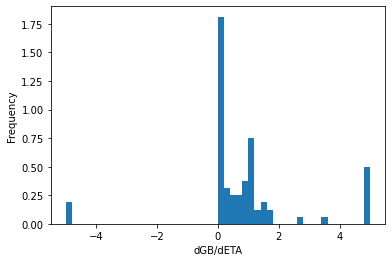

In [297]:
deltaGB_deltaETA_and_ETA
l = [min(max(e, -5), 5) for e in deltaGB_deltaETA_and_ETA]
plt.hist(l, bins=50, density=True)
plt.ylabel('Frequency')
plt.xlabel('dGB/dETA')

In [328]:
print(np.mean(np.array(overwrite_gained_gb)))
print(np.mean(np.array(smart_ow_gained_gb)))

4.301551138510202
1.4422774571106882


In [329]:
print(np.mean(np.array(overwrite_gained_ETA)))
print(np.mean(np.array(smart_ow_gained_ETA)))

5.5661876962333725
-10.247066628810492


In [325]:
len(overwrite_gained_gb)

906